In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


In [2]:
# Generate data paths with labels
data_dir = "E:/A__CVPR/Dataset/Classes"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
df

,filepaths,labels
0,E:/A__CVPR/Dataset/Classes\Atelectasis\0000001...,Atelectasis
1,E:/A__CVPR/Dataset/Classes\Atelectasis\0000003...,Atelectasis
2,E:/A__CVPR/Dataset/Classes\Atelectasis\0000003...,Atelectasis
3,E:/A__CVPR/Dataset/Classes\Atelectasis\0000003...,Atelectasis
4,E:/A__CVPR/Dataset/Classes\Atelectasis\0000004...,Atelectasis
...,...,...
27548,E:/A__CVPR/Dataset/Classes\Pneumothorax\000306...,Pneumothorax
27549,E:/A__CVPR/Dataset/Classes\Pneumothorax\000306...,Pneumothorax
27550,E:/A__CVPR/Dataset/Classes\Pneumothorax\000306...,Pneumothorax
27551,E:/A__CVPR/Dataset/Classes\Pneumothorax\000306...,Pneumothorax


In [4]:
# Split dataframe into train, validation, and test sets
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)


In [5]:
# Image properties
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended: use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# This function will be used in image data generator for data augmentation, it just takes the image and returns it again.
def scalar(img):
    return img

# Data augmentation
tr_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# Note: we will use custom test_batch_size, and make shuffle=False
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 22042 validated image filenames belonging to 13 classes.
Found 3306 validated image filenames belonging to 13 classes.
Found 2205 validated image filenames belonging to 13 classes.


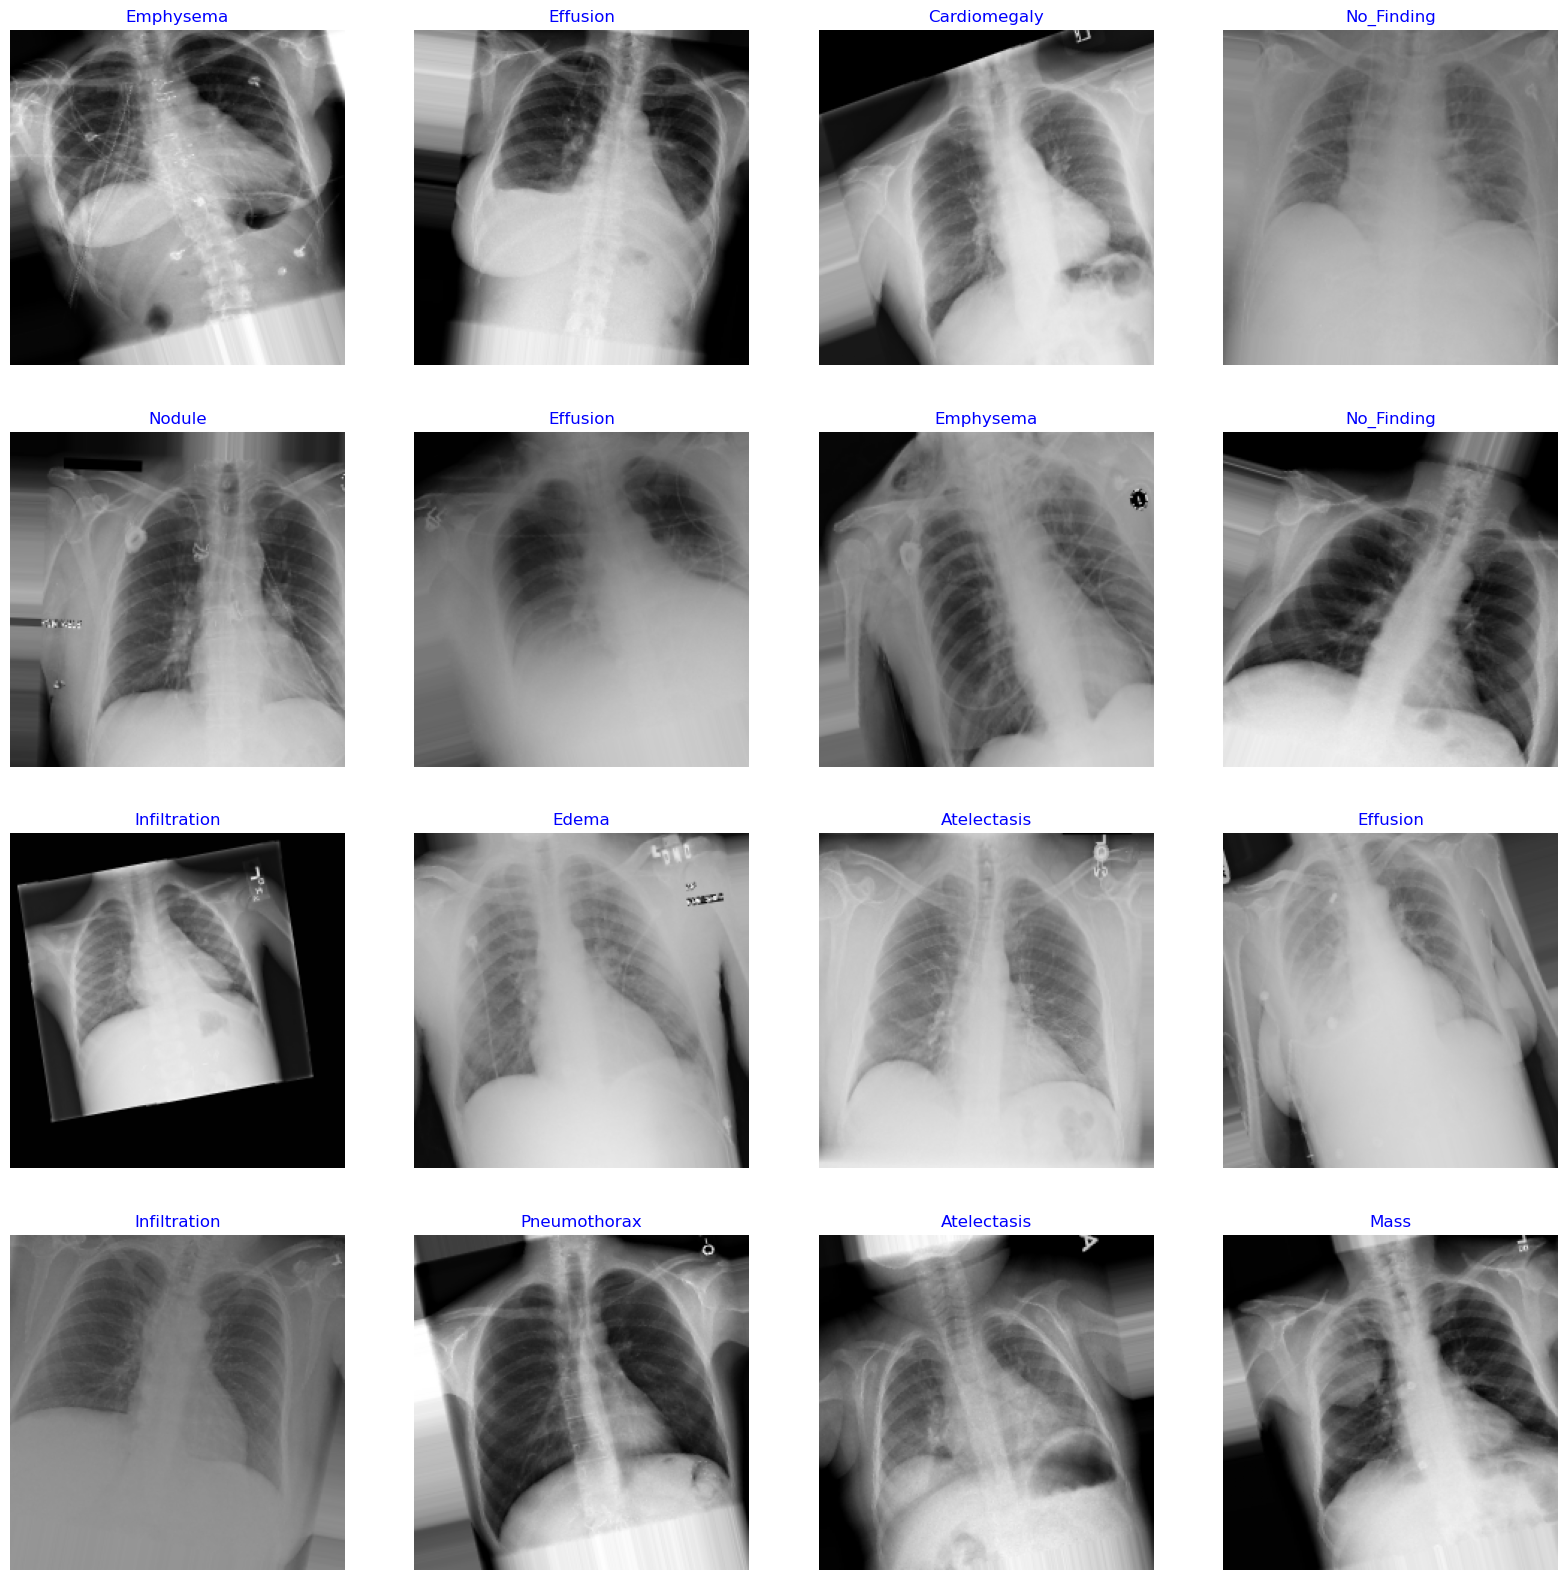

In [6]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), class names: string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


In [7]:
# Create Model Structure
img_size = (64, 64)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define number of classes in dense layer

# Create pre-trained model (you can build on pretrained model such as: EfficientNet, VGG, Resnet)
# We will use EfficientNetB0 from EfficientNet family.
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='avg'
)

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                3341      
                                                                 
Total params: 4,385,968
Trainable params: 4,341,385
Non-trainable params: 44,583
_________________________________________

In [9]:

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[reduce_lr, early_stopping], shuffle=False)


Epoch 1/10
1378/1378 [==============================] - 586s 425ms/step - loss: 3.2575 - accuracy: 0.2524 - val_loss: 2.3329 - val_accuracy: 0.2961 - lr: 0.0010
Epoch 2/10
1378/1378 [==============================] - 506s 367ms/step - loss: 2.3138 - accuracy: 0.2805 - val_loss: 2.2872 - val_accuracy: 0.3091 - lr: 0.0010
Epoch 3/10
1378/1378 [==============================] - 507s 368ms/step - loss: 2.3127 - accuracy: 0.2863 - val_loss: 2.2055 - val_accuracy: 0.3285 - lr: 0.0010
Epoch 4/10
1378/1378 [==============================] - 502s 364ms/step - loss: 2.2570 - accuracy: 0.2923 - val_loss: 2.2036 - val_accuracy: 0.3088 - lr: 0.0010
Epoch 5/10
1378/1378 [==============================] - 491s 356ms/step - loss: 2.1942 - accuracy: 0.3124 - val_loss: 2.1868 - val_accuracy: 0.2886 - lr: 0.0010
Epoch 6/10
1378/1378 [==============================] - 491s 356ms/step - loss: 2.1142 - accuracy: 0.3346 - val_loss: 2.1370 - val_accuracy: 0.3016 - lr: 0.0010
Epoch 7/10
1378/1378 [============

In [10]:
# Evaluate the model
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Plot training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

35/35 [==============================] - 61s 1s/step - loss: 2.2657 - accuracy: 0.2730
Train Loss:  1.9974720478057861
Train Accuracy:  0.375
--------------------
Validation Loss:  2.25642991065979
Validation Accuracy:  0.2785714268684387
--------------------
Test Loss:  2.265738010406494
Test Accuracy:  0.2730158865451813


In [ ]:
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))